<a href="https://colab.research.google.com/github/AIsavvyAyeshafathima/Normalizing-Flow-Models/blob/main/RealNVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.datasets import make_moons
import tensorflow_probability as tfp

In [2]:
# Generate dataset
X_train, _ = make_moons(n_samples=1000, noise=0.05)
X_train = X_train.astype(np.float32)

# Normalize the data
X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)


In [12]:
class CouplingLayer(layers.Layer):
    def __init__(self):
        super(CouplingLayer, self).__init__()
        # Define two separate models for scale and translation
        self.scale_net = keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='tanh')  # Output scaling factor
        ])
        self.translation_net = keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)  # Output translation vector
        ])

    def call(self, inputs, reverse=False):
        x1, x2 = tf.split(inputs, num_or_size_splits=2, axis=1)

        if reverse:
            # Reverse flow for sampling
            scale = self.scale_net(x2)
            translation = self.translation_net(x2)
            x1 = (x1 - translation) / tf.exp(scale)
        else:
            # Forward flow for training
            scale = self.scale_net(x1)
            translation = self.translation_net(x1)
            x2 = x2 * tf.exp(scale) + translation

        return tf.concat([x1, x2], axis=1)


In [13]:
class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers):
        super(RealNVP, self).__init__()
        self.coupling_layers = [CouplingLayer() for _ in range(num_coupling_layers)]
        self.base_distribution = tfp.distributions.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[1., 1.])

    def call(self, inputs, reverse=False):
        z = inputs
        log_det_jacobian = 0.

        if reverse:
            # Reverse flow for sampling
            for layer in reversed(self.coupling_layers):
                z = layer(z, reverse=True)
        else:
            # Forward flow for training
            for layer in self.coupling_layers:
                z = layer(z)
                # Pass only the second half of the output to scale_net
                log_det_jacobian += tf.reduce_sum(layer.scale_net(z[:, 1:])) # Only pass the second half

        return z, log_det_jacobian

    def log_prob(self, inputs):
        z, log_det_jacobian = self(inputs)
        log_prob_z = self.base_distribution.log_prob(z)
        return log_prob_z + log_det_jacobian

In [14]:
def train_realnvp(model, data, epochs=600, batch_size=128):
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    loss_values = []

    dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(1000).batch(batch_size)

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_data in dataset:
            with tf.GradientTape() as tape:
                log_prob = model.log_prob(batch_data)
                loss = -tf.reduce_mean(log_prob)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            epoch_loss += loss.numpy()

        loss_values.append(epoch_loss / len(dataset))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(dataset)}")

    return loss_values


Epoch 1/600, Loss: -187.23537576198578
Epoch 2/600, Loss: -413.14147567749023
Epoch 3/600, Loss: -485.573917388916
Epoch 4/600, Loss: -531.2566986083984
Epoch 5/600, Loss: -566.3365440368652
Epoch 6/600, Loss: -588.513484954834
Epoch 7/600, Loss: -602.7327270507812
Epoch 8/600, Loss: -613.1742477416992
Epoch 9/600, Loss: -622.7612075805664
Epoch 10/600, Loss: -632.380256652832
Epoch 11/600, Loss: -640.7063369750977
Epoch 12/600, Loss: -650.3434448242188
Epoch 13/600, Loss: -660.0544891357422
Epoch 14/600, Loss: -666.5977783203125
Epoch 15/600, Loss: -672.5388107299805
Epoch 16/600, Loss: -679.9096450805664
Epoch 17/600, Loss: -683.9948806762695
Epoch 18/600, Loss: -688.4147491455078
Epoch 19/600, Loss: -691.8120803833008
Epoch 20/600, Loss: -692.1158981323242
Epoch 21/600, Loss: -692.8403778076172
Epoch 22/600, Loss: -697.4212875366211
Epoch 23/600, Loss: -698.7188949584961
Epoch 24/600, Loss: -700.4447631835938
Epoch 25/600, Loss: -701.1121673583984
Epoch 26/600, Loss: -699.6384811401

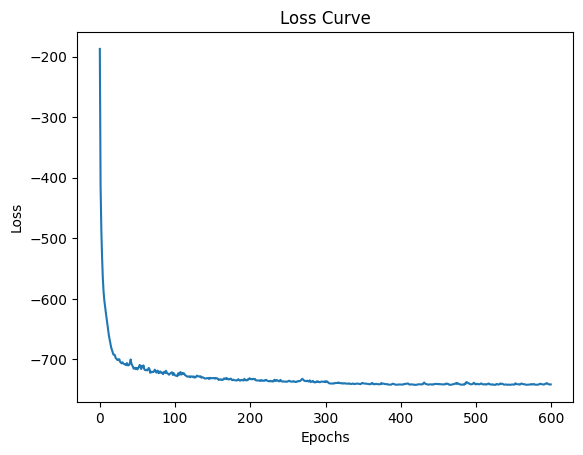

In [15]:
# Instantiate and train the model
num_coupling_layers = 6
realnvp_model = RealNVP(num_coupling_layers)

loss_values = train_realnvp(realnvp_model, X_train)

# Plot the loss curve
plt.plot(loss_values)
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
